Throughout this interpretability series, I'll mainly focus on *model-agnostic methods* which are appropriate for any type of model from linear regression to multilayer perceptrons. The following, *partial dependence plot*, is a model-agnostic method.

Idea is very simple. Actually, I remember making use of it before knowing any method although I wasn't aware of its limitations... Below, I have a model trained on Euroleague play-by-play data, which uses cumulative three point attempts (cum_P3A), cumulative three point makes (cum_P3M), shot angle, shot zone area to predict whether the shot will go in or not in the upcoming three point attempt.

In [15]:
rf_bayes_search = BayesSearchCV(
    rf,
    rf_param_grid,
    n_iter=20,      
    cv=skf.split(X_train, y_train),           
    scoring='neg_log_loss',
    n_jobs=-2,
    random_state=0
)

rf_bayes_search.fit(X_train, y_train)

,estimator,RandomForestC...andom_state=0)
,search_spaces,"{'class_weight': ['balanced'], 'max_depth': (3, ...), 'max_features': (0.3, ...), 'min_samples_leaf': (30, ...), ...}"
,optimizer_kwargs,None
,n_iter,20
,scoring,'neg_log_loss'
,fit_params,None
,n_jobs,-2
,n_points,1
,iid,'deprecated'
,refit,True
,cv,<generator ob...t 0x28c08eac0>


Let's say we want to know the affect of cum_P3A on the prediction. We create a grid of values for cum_P3A and for each observation in our dataset, we set the value of cum_P3A to the first value of the grid. We keep all the other variables the same, and make predictions via our model for each row. Then, average those.

So, for example, for the value of 5 we go through each row within the dataframe and set the cum_P3A to 5 and make predictions and average those.

When we repeat the process for each value in the grid, we get the *partial dependence function* for cum_P3A:

$\displaystyle \text{PD}_{cum3PA} = \frac{1}{N} \sum^{N}_{i=1} \hat{f}(x_{cum3PA}, x_{-cum3PA}^{i})$

In [19]:
grid = np.arange(0, 80)

In [ ]:
list_ice = []

for i, row in sampled_df.iterrows():
    tmp_df = pd.DataFrame([row.values] * len(grid), columns=sampled_df.columns)
    tmp_df['cum_P3A'] = grid
    tmp_probas = rf_bayes_search.best_estimator_.predict_proba(tmp_df)[:, 1]
    tmp_df['probas'] = tmp_probas
    tmp_df['idx'] = i

    list_ice.append(tmp_df)

In [22]:
avg_preds = []

for val in sorted(full_df['cum_P3A'].unique().tolist()):

    avg_preds.append(np.mean(full_df.loc[full_df['cum_P3A'] == val, 'probas']))

Text(0, 0.5, 'Prediction')

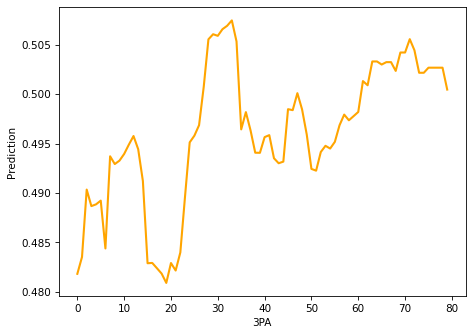

In [23]:
plt.figure(figsize=(7, 5))

plt.plot(grid, avg_preds, lw=2, color='orange')

plt.xlabel('3PA')
plt.ylabel('Prediction')

So, that's the partial dependence plot (PDP) for a cum_3PA. There are two problems that should worry you:

1) We miss out on heterogenous effects. A relatively flat line might be due to not having any affect at all or due to heterogenous effects canceling each other out. Individual conditional expectation (ICE) plots can help with that, which I show below.
2) I didn't choose cum_3PA arbitrarily. We don't take joint distribution into account with PDP which may result us ending up with counterfactual rows that are not likely or even possible in this case. For example, for a row that has 10 as cum_3PM, having anything less than 10 for cum_3PA doesn't make any sense at all but we allow that. I'll show the joint distribution but before that, let's start with ICEs.

Text(0, 0.5, 'Prediction')

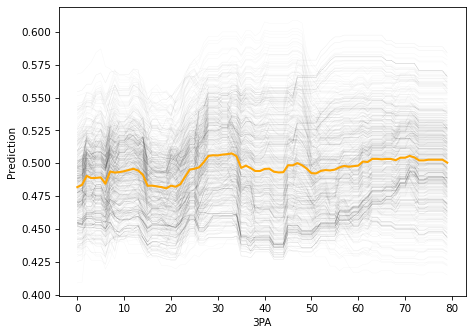

In [24]:
plt.figure(figsize=(7, 5))

for idx in full_df['idx'].unique().tolist():
    plt.plot(
        full_df.loc[full_df['idx'] == idx, 'cum_P3A'],
        full_df.loc[full_df['idx'] == idx, 'probas'],
        alpha=.03,
        color='black',
        lw=0.5
        )

plt.plot(grid, avg_preds, lw=2, color='orange')

plt.xlabel('3PA')
plt.ylabel('Prediction')

Those black lines are ICEs, where each line corresponds to a single row. The orange line is the partial dependence curve. They are related since PDP is the average of those ICEs. 

Luckily, we don't have to write those codes ourselves (I only did that for demonstrative purposes), sklearn has a built in function for it.

In [25]:
from sklearn.inspection import PartialDependenceDisplay

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


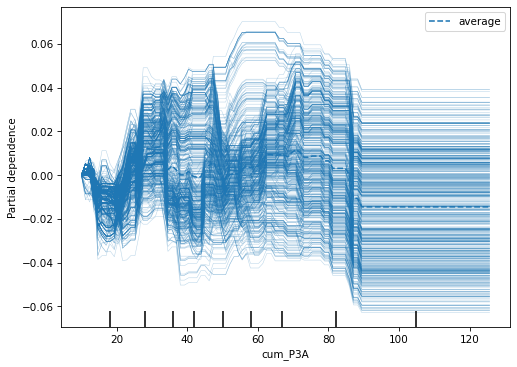

In [27]:
fig, ax = plt.subplots(figsize=(7, 5))

PartialDependenceDisplay.from_estimator(
    rf_bayes_search.best_estimator_, 
    sampled_df, 
    features=['cum_P3A'], 
    ax=ax,
    kind='both',
    centered=True
)

plt.tight_layout()
plt.show()

Centering the ICEs makes it easier to compare the effect of a variable between different rows, so `centered=True`. Also, the rugs on the bottom helps with the variable's distribution so that you can understand where the distribution is more dense and interpret accordingly. However, that doesn't take joint distribution into account:

Text(0, 0.5, 'P3M')

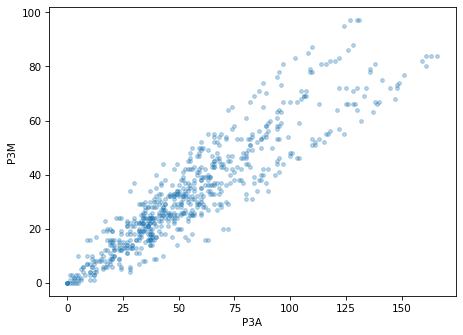

In [28]:
plt.figure(figsize=(7, 5))

plt.scatter(
    sampled_df['cum_P3A'], sampled_df['cum_P3M'],
    alpha=.3,
    s=13
)

plt.xlabel('P3A')
plt.ylabel('P3M')

Marginal distribution for cum_P3A covers a wide range, as it is apparent from the x-axis of the scatter plot. However, when we condition on, let's say cum_P3M = 30, things differ:

<Axes: xlabel='cum_P3A', ylabel='Density'>

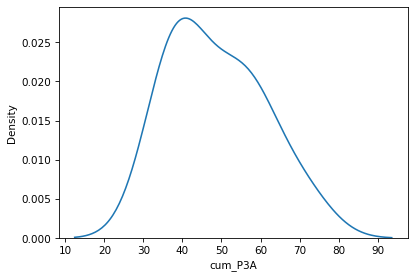

In [29]:
plt.figure(figsize=(6,4))

sns.kdeplot(sampled_df.loc[sampled_df['cum_P3M'] == 30, 'cum_P3A'])

Some values for cum_P3A doesn't make any sense at all, like having lower number of attempts than made shots. Some others are highly unlikely, like making 30 in 30 attempts. I'll talk about *Accumulated Local Effects (ALE)* in a different post, where it addresses the correlation issue.

Despite its limitations, I like PDPs since the idea is very intuitive: Tracking the average prediction as I vary a particular variable. Also, you can make use of it in aggregate or certain portions of the data. ICEs are nice as well, although the plot gets extremely crowded if you have a relatively big data (I used a small sample due to this issue, for demonstrative purposes).

As long as you keep the limitations in mind, you should be fine :)